In [39]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random
import sklearn
import collections
from sklearn.model_selection import train_test_split
import json
import pylab
from scipy.optimize import curve_fit
from tensorflow.keras import layers, Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc
import matplotlib
import matplotlib.patches as mpatches
import shap
import os
import pandas as pd
import matplotlib
import matplotlib.patches as mpatches

In [7]:
# Set matplotlib default color cycle
new_color_cycle = [
    '#1f77b4',
    '#ff7f0e',
    '#2ca02c',
    '#d62728',
    '#9467bd',
    '#8c564b',
    '#e377c2',
    '#7f7f7f',
    '#bcbd22',
    '#17becf',
    '#aec7e8',
    '#ffbb78',
    '#98df8a',
    '#ff9896',
    '#c5b0d5',
    '#c49c94',
    '#f7b6d2',
    '#c7c7c7',
    '#dbdb8d',
    '#9edae5'
]

# You can then apply this new color cycle to your matplotlib plots
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=new_color_cycle)

# Okay, now I'll try training only over passL1 events

In [8]:
# This is the list that will hold all of the data (data22 and MC)

datasets = {}

## Collect Data

In [9]:
with h5py.File('../../../../ntuples/AOD_EB_ntuples_05-22-2024.h5', 'r') as hf:
    HLT_jets = hf['HLT_jets'][:]
    ofl_jets = hf['ofl_jets'][:]
    L1_jFexSR_jets = hf['L1_jFexSR_jets'][:]
    L1_jFexLR_jets = hf['L1_jFexLR_jets'][:]
    HLT_electrons = hf['HLT_electrons'][:]
    LRT_electrons = hf['LRT_electrons'][:]
    ofl_electrons = hf['ofl_electrons'][:]
    L1_egammas = hf['L1_egammas'][:]
    HLT_muons = hf['HLT_muons'][:]
    LRT_muons = hf['LRT_muons'][:]
    ofl_muons = hf['ofl_muons'][:]
    L1_muons = hf['L1_muons'][:]
    L1_eFex_taus = hf['L1_eFex_taus'][:]
    L1_jFex_taus = hf['L1_jFex_taus'][:]
    HLT_photons = hf['HLT_photons'][:]
    ofl_photons = hf['ofl_photons'][:]
    HLT_MET = hf['HLT_MET'][:].reshape(-1, 1, 3)  # Broadcasting MET
    L1_MET = hf['L1_MET'][:].reshape(-1, 1, 3)
    pass_L1_unprescaled = hf["pass_L1_unprescaled"][:]
    pass_HLT_unprescaled = hf["pass_HLT_unprescaled"][:]
    EB_weights = hf["EB_weights"][:]
    event_number = hf["event_number"][:]
    run_number = hf["run_number"][:]


# Concatenate HLT data
HLT_objects = np.concatenate([HLT_jets[:, :, [0, 2, 3]], HLT_electrons, HLT_muons, HLT_photons, HLT_MET], axis=1)
L1_objects = np.concatenate([L1_jFexSR_jets, L1_egammas, L1_muons, L1_eFex_taus, L1_MET], axis=1)

datasets['EB'] = {
    'HLT_data': HLT_objects,
    'L1_data': L1_objects,
    'passL1': pass_L1_unprescaled==1,
    'passHLT': pass_HLT_unprescaled==1,
    'weights': EB_weights,
    'event_numbers': event_number,
    'run_numbers': run_number
}

In [10]:
# Read MC data.

data_path = '../../../../ntuples/L1_MC/'

for filename in os.listdir(data_path):

    if filename.startswith('HLT') or filename.startswith('.'): continue

    dataset_tag = filename.split('_')[0]
    
    with h5py.File(data_path+filename, 'r') as hf:
        HLT_jets = hf['HLT_jets'][:]
        L1_jFexSR_jets = hf['L1_jFexSR_jets'][:]
        L1_jFexLR_jets = hf['L1_jFexLR_jets'][:]
        HLT_electrons = hf['HLT_electrons'][:]
        LRT_electrons = hf['LRT_electrons'][:]
        L1_egammas = hf['L1_egammas'][:]
        HLT_muons = hf['HLT_muons'][:]
        LRT_muons = hf['LRT_muons'][:]
        L1_muons = hf['L1_muons'][:]
        L1_eFex_taus = hf['L1_eFex_taus'][:]
        L1_jFex_taus = hf['L1_jFex_taus'][:]
        HLT_photons = hf['HLT_photons'][:]
        HLT_MET = hf['HLT_MET'][:].reshape(-1, 1, 4)  # Broadcasting MET
        L1_MET = hf['L1_MET'][:].reshape(-1, 1, 3)
        pass_L1_unprescaled = hf["pass_L1_unprescaled"][:]
        pass_HLT_unprescaled = hf["pass_HLT_unprescaled"][:]

        HLT_objects = np.concatenate([HLT_jets[:, :, [0, 2, 3]], HLT_electrons[:, :3, [0, 2, 3]], HLT_muons[:, :3, [0, 2, 3]], HLT_photons[:, :3, [0, 2, 3]], HLT_MET[:, :, [0, 2, 3]]], axis=1)
        L1_objects = np.concatenate([L1_jFexSR_jets, L1_egammas[:, :3, :], L1_muons[:, :3, :], L1_eFex_taus[:, :3, :], L1_MET], axis=1)
        
        datasets[dataset_tag] = {
            'HLT_data': HLT_objects,
            'L1_data': L1_objects,
            'passL1': pass_L1_unprescaled==1,
            'passHLT': pass_HLT_unprescaled==1,
            'weights': np.ones(len(HLT_objects)),
        }

In [11]:
for tag, dict in datasets.items():
    print(f'\n{tag}:')
    for key, value in dict.items():
        print(f'{key}: {value.shape}')


EB:
HLT_data: (2059879, 20, 3)
L1_data: (2059879, 20, 3)
passL1: (2059879,)
passHLT: (2059879,)
weights: (2059879,)
event_numbers: (2059879,)
run_numbers: (2059879,)

A14N23LO:
HLT_data: (10000, 20, 3)
L1_data: (10000, 20, 3)
passL1: (10000,)
passHLT: (10000,)
weights: (10000,)

HAHMggf:
HLT_data: (70000, 20, 3)
L1_data: (70000, 20, 3)
passL1: (70000,)
passHLT: (70000,)
weights: (70000,)

HHbbttHadHad:
HLT_data: (100000, 20, 3)
L1_data: (100000, 20, 3)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)

ZZ4lep:
HLT_data: (100000, 20, 3)
L1_data: (100000, 20, 3)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)

Zprime2EJs:
HLT_data: (100000, 20, 3)
L1_data: (100000, 20, 3)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)

jjJZ2:
HLT_data: (100000, 20, 3)
L1_data: (100000, 20, 3)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)

jjJZ4:
HLT_data: (100000, 20, 3)
L1_data: (100000, 20, 3)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)

qqa:
HLT_data: (500

In [12]:
# Read additional data from collaborator
with h5py.File('../../../../ntuples/aux_data/For_Max4.h5', 'r') as hf:
    L1_AD_scores = hf['AD_Scores'][:]
    L1_event_number = hf['event_number'][:]
    L1_run_number = hf['run_number'][:]

# Create train and eval masks based on AD scores
train_mask = (L1_AD_scores == 0)
train_evt_num = L1_event_number[train_mask]
train_run_num = L1_run_number[train_mask]
eval_evt_num = L1_event_number[~train_mask]
eval_run_num = L1_run_number[~train_mask]
train_AD_scores = L1_AD_scores[train_mask]
eval_AD_scores = L1_AD_scores[~train_mask]

# Create a mapping from (event_number, run_number) to AD_score
event_run_to_ad_score = {(event, run): score for event, run, score in zip(L1_event_number, L1_run_number, L1_AD_scores)}

# Function to filter dataset based on event and run numbers, and add AD scores
def filter_dataset_by_event_run(dataset, event_numbers, run_numbers):
    mask = np.isin(dataset['event_numbers'], event_numbers) & np.isin(dataset['run_numbers'], run_numbers)
    filtered_dataset = {key: value[mask] for key, value in dataset.items()}
    ad_scores = np.array([event_run_to_ad_score[(evt, run)] for evt, run in zip(filtered_dataset['event_numbers'], filtered_dataset['run_numbers'])])
    filtered_dataset['L1_AD_scores'] = ad_scores
    return filtered_dataset

# Create training and evaluation datasets for 'EB'
datasets['EB_train'] = filter_dataset_by_event_run(datasets['EB'], train_evt_num, train_run_num)
datasets['EB_eval'] = filter_dataset_by_event_run(datasets['EB'], eval_evt_num, eval_run_num)

# Remove the 'EB' sub-dictionary as it is no longer needed
del datasets['EB']

# Display the structure of updated datasets
for tag, data in datasets.items():
    print(f'\n{tag}:')
    for key, value in data.items():
        print(f'{key}: {value.shape}')


A14N23LO:
HLT_data: (10000, 20, 3)
L1_data: (10000, 20, 3)
passL1: (10000,)
passHLT: (10000,)
weights: (10000,)

HAHMggf:
HLT_data: (70000, 20, 3)
L1_data: (70000, 20, 3)
passL1: (70000,)
passHLT: (70000,)
weights: (70000,)

HHbbttHadHad:
HLT_data: (100000, 20, 3)
L1_data: (100000, 20, 3)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)

ZZ4lep:
HLT_data: (100000, 20, 3)
L1_data: (100000, 20, 3)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)

Zprime2EJs:
HLT_data: (100000, 20, 3)
L1_data: (100000, 20, 3)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)

jjJZ2:
HLT_data: (100000, 20, 3)
L1_data: (100000, 20, 3)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)

jjJZ4:
HLT_data: (100000, 20, 3)
L1_data: (100000, 20, 3)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)

qqa:
HLT_data: (50000, 20, 3)
L1_data: (50000, 20, 3)
passL1: (50000,)
passHLT: (50000,)
weights: (50000,)

EB_train:
HLT_data: (1000000, 20, 3)
L1_data: (1000000, 20, 3)
passL1: (100000

In [13]:
# Create the L1Seeded flag for the evaluation dataset
acceptance = 0
target_acceptance = 1e-5
datasets['EB_eval']['L1Seeded'] = np.full(len(datasets['EB_eval']['event_numbers']), False, dtype=bool)

# Sort indices by AD score in descending order
sorted_indices = np.argsort(datasets['EB_eval']['L1_AD_scores'])[::-1]

# Calculate the sum of the weights once so we don't do it every time in the loop
sum_weights = np.sum(datasets['EB_eval']['weights'])

for idx in sorted_indices:
    if acceptance >= target_acceptance:
        break
    datasets['EB_eval']['L1Seeded'][idx] = True
    acceptance += datasets['EB_eval']['weights'][idx] / sum_weights

# Display the structure of updated datasets
for tag, data in datasets.items():
    print(f'\n{tag}:')
    for key, value in data.items():
        print(f'{key}: {value.shape}')


A14N23LO:
HLT_data: (10000, 20, 3)
L1_data: (10000, 20, 3)
passL1: (10000,)
passHLT: (10000,)
weights: (10000,)

HAHMggf:
HLT_data: (70000, 20, 3)
L1_data: (70000, 20, 3)
passL1: (70000,)
passHLT: (70000,)
weights: (70000,)

HHbbttHadHad:
HLT_data: (100000, 20, 3)
L1_data: (100000, 20, 3)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)

ZZ4lep:
HLT_data: (100000, 20, 3)
L1_data: (100000, 20, 3)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)

Zprime2EJs:
HLT_data: (100000, 20, 3)
L1_data: (100000, 20, 3)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)

jjJZ2:
HLT_data: (100000, 20, 3)
L1_data: (100000, 20, 3)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)

jjJZ4:
HLT_data: (100000, 20, 3)
L1_data: (100000, 20, 3)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)

qqa:
HLT_data: (50000, 20, 3)
L1_data: (50000, 20, 3)
passL1: (50000,)
passHLT: (50000,)
weights: (50000,)

EB_train:
HLT_data: (1000000, 20, 3)
L1_data: (1000000, 20, 3)
passL1: (100000

In [14]:
print(datasets['EB_eval']['L1Seeded'][:5])
print(np.sum(datasets['EB_eval']['L1Seeded']))

[False False False False False]
1988


In [15]:
# Now, in the eval/training sets, only take events that either passed L1, or are L1Seeded

mask = datasets['EB_eval']['passL1'] | datasets['EB_eval']['L1Seeded']
for label, data in datasets['EB_eval'].items():
    datasets['EB_eval'][label] = data[mask]

mask = datasets['EB_train']['passL1']
for label, data in datasets['EB_train'].items():
    datasets['EB_train'][label] = data[mask]

In [16]:
"""Met bias. For some events, MET was not calculated, so was written as -999.
We don't want this to impact training, so we map 0 --> 0.001 and -999 --> 0"""
for tag, dict in datasets.items():
    for label, data in dict.items():
        if label.endswith('data'):

            # MET: 0 --> 0.001 and -999 --> 0 and nan --> 0
            MET_zeros = (data[:, 19, 0] == 0) # indices where MET=0
            MET_999 = ((data[:, 19, 0] == -999)) # indices where MET=-999 (not calculated)
            MET_nan = np.isnan(data[:, 19, 2])
            data[MET_zeros, 19, 0] = 0.001
            data[MET_999, 19, :] = 0
            data[MET_nan, 19, :] = 0

In [17]:
"""Multiply the et of the L1 muons by 1000 to get them into the right units."""
for tag, dict in datasets.items():
    for label, data in dict.items():
        if label == 'L1_data':
            data[:, 13:16, 0] *= 1000

## Final preprocessing of data

In [18]:
"""Normalize pt """
for tag, dict in datasets.items():
    for label, data in dict.items():
        if label.endswith('data'):
            # sum of the pt and E in each event
            sum_pt = np.sum(data[:, :, 0], axis=1, keepdims=True)
        
            # If the sum is 0, set the sum to 1 to avoid division by 0
            sum_pt[sum_pt == 0] = 1
        
            # Divide pt and E by their respective sums
            data[:, :, 0] /= (sum_pt)

In [19]:
# Display the structure of updated datasets
for tag, data in datasets.items():
    print(f'\n{tag}:')
    for key, value in data.items():
        print(f'{key}: {value.shape}')


A14N23LO:
HLT_data: (10000, 20, 3)
L1_data: (10000, 20, 3)
passL1: (10000,)
passHLT: (10000,)
weights: (10000,)

HAHMggf:
HLT_data: (70000, 20, 3)
L1_data: (70000, 20, 3)
passL1: (70000,)
passHLT: (70000,)
weights: (70000,)

HHbbttHadHad:
HLT_data: (100000, 20, 3)
L1_data: (100000, 20, 3)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)

ZZ4lep:
HLT_data: (100000, 20, 3)
L1_data: (100000, 20, 3)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)

Zprime2EJs:
HLT_data: (100000, 20, 3)
L1_data: (100000, 20, 3)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)

jjJZ2:
HLT_data: (100000, 20, 3)
L1_data: (100000, 20, 3)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)

jjJZ4:
HLT_data: (100000, 20, 3)
L1_data: (100000, 20, 3)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)

qqa:
HLT_data: (50000, 20, 3)
L1_data: (50000, 20, 3)
passL1: (50000,)
passHLT: (50000,)
weights: (50000,)

EB_train:
HLT_data: (172051, 20, 3)
L1_data: (172051, 20, 3)
passL1: (172051,)

In [20]:
# Flatten ndarrays for use in DNN

for tag, dict in datasets.items():
    for label, data in dict.items():
        if label.endswith('data'):
            datasets[tag][label] = np.reshape(data, newshape=(-1, 60))

# Display the structure of updated datasets
for tag, data in datasets.items():
    print(f'\n{tag}:')
    for key, value in data.items():
        print(f'{key}: {value.shape}')


A14N23LO:
HLT_data: (10000, 60)
L1_data: (10000, 60)
passL1: (10000,)
passHLT: (10000,)
weights: (10000,)

HAHMggf:
HLT_data: (70000, 60)
L1_data: (70000, 60)
passL1: (70000,)
passHLT: (70000,)
weights: (70000,)

HHbbttHadHad:
HLT_data: (100000, 60)
L1_data: (100000, 60)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)

ZZ4lep:
HLT_data: (100000, 60)
L1_data: (100000, 60)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)

Zprime2EJs:
HLT_data: (100000, 60)
L1_data: (100000, 60)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)

jjJZ2:
HLT_data: (100000, 60)
L1_data: (100000, 60)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)

jjJZ4:
HLT_data: (100000, 60)
L1_data: (100000, 60)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)

qqa:
HLT_data: (50000, 60)
L1_data: (50000, 60)
passL1: (50000,)
passHLT: (50000,)
weights: (50000,)

EB_train:
HLT_data: (172051, 60)
L1_data: (172051, 60)
passL1: (172051,)
passHLT: (172051,)
weights: (172051,)
event_numbers: 

## Network Infrastructure

In [21]:
def create_AE(input_dim, h_dim_1, h_dim_2, latent_dim):
    
     # Encoder
    encoder_inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(h_dim_1, activation='relu')(encoder_inputs)
    x = layers.Dense(h_dim_2, activation='relu')(x)
    z = layers.Dense(latent_dim, activation='relu')(x)
    
    encoder = Model(inputs=encoder_inputs, outputs=z)

    # Decoder
    decoder_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(h_dim_2, activation='relu')(decoder_inputs)
    x = layers.Dense(h_dim_1, activation='relu')(x)
    outputs = layers.Dense(input_dim)(x)

    decoder = Model(inputs=decoder_inputs, outputs=outputs)

    ae_outputs = decoder(encoder(encoder_inputs))
    ae = Model(encoder_inputs, outputs=ae_outputs)

    return ae, encoder, decoder

In [22]:
def loss_fn(y_true, y_pred):
    """masked mse"""
    mask0 = K.cast(K.not_equal(y_true, 0), K.floatx())
    maskMET = K.cast(K.not_equal(y_true, -999), K.floatx())
    mask = mask0 * maskMET
    squared_difference = K.square(mask * (y_pred - y_true))
    return K.mean(squared_difference)

## Train

In [23]:
# Initialize models
INPUT_DIM = datasets['EB_train']['HLT_data'].shape[1]
H_DIM_1 = 32
H_DIM_2 = 8
LATENT_DIM = 3

HLT_AE, HLT_encoder, HLT_decoder = create_AE(input_dim=INPUT_DIM, h_dim_1=H_DIM_1, h_dim_2=H_DIM_2, latent_dim=LATENT_DIM)
L1_AE, L1_encoder, L1_decoder = create_AE(input_dim=INPUT_DIM, h_dim_1=H_DIM_1, h_dim_2=H_DIM_2, latent_dim=LATENT_DIM)

HLT_AE.summary()
L1_AE.summary()

2024-06-07 18:39:29.392513: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-07 18:39:29.422764: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-07 18:39:29.423023: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60)]              0         
                                                                 
 model (Functional)          (None, 3)                 2243      
                                                                 
 model_1 (Functional)        (None, 60)                2300      
                                                                 
Total params: 4543 (17.75 KB)
Trainable params: 4543 (17.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 60)]              0         
                                                                 
 model_3

In [24]:
HLT_AE.compile(optimizer='adam', loss=loss_fn)
L1_AE.compile(optimizer='adam', loss=loss_fn)

In [25]:
# Define callbacks: early stopping and learning rate scheduler

STOP_PATIENCE = 8
LR_PATIENCE = 4

early_stopping = EarlyStopping(patience=STOP_PATIENCE, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=LR_PATIENCE, verbose=1)

callbacks = [early_stopping, reduce_lr]

In [26]:
NUM_EPOCHS = 150
BATCH_SIZE = 512

In [30]:
# train HLT model
history = HLT_AE.fit(
    x=datasets['EB_train']['HLT_data'], 
    y=datasets['EB_train']['HLT_data'], 
    validation_split=0.15, 
    epochs=NUM_EPOCHS, 
    batch_size=BATCH_SIZE, 
    callbacks=callbacks, 
    sample_weight = datasets['EB_train']['weights']
)

Epoch 1/150


2024-06-05 19:59:39.412695: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa7899c4240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-05 19:59:39.412749: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-06-05 19:59:39.427771: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-05 19:59:39.463201: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-06-05 19:59:39.664604: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


286/286 [==============================] - 5s 6ms/step - loss: 1028.2848 - val_loss: 782.2897 - lr: 0.0010
Epoch 2/150
286/286 [==============================] - 1s 5ms/step - loss: 913.8619 - val_loss: 765.8043 - lr: 0.0010
Epoch 3/150
286/286 [==============================] - 1s 5ms/step - loss: 903.4824 - val_loss: 761.8107 - lr: 0.0010
Epoch 4/150
286/286 [==============================] - 1s 5ms/step - loss: 900.2169 - val_loss: 759.7311 - lr: 0.0010
Epoch 5/150
286/286 [==============================] - 1s 5ms/step - loss: 898.2491 - val_loss: 758.6406 - lr: 0.0010
Epoch 6/150
286/286 [==============================] - 1s 4ms/step - loss: 896.7069 - val_loss: 756.2036 - lr: 0.0010
Epoch 7/150
286/286 [==============================] - 1s 4ms/step - loss: 894.1804 - val_loss: 753.2388 - lr: 0.0010
Epoch 8/150
286/286 [==============================] - 1s 5ms/step - loss: 889.6670 - val_loss: 749.3255 - lr: 0.0010
Epoch 9/150
286/286 [==============================] - 1s 4ms/step 

In [31]:
HLT_AE.save_weights('./trained_models/EB_HLT_v8.keras')
HLT_encoder.save_weights('./trained_models/EB_HLT_encoder_v8.keras')

In [27]:
HLT_AE.load_weights('./trained_models/EB_HLT_v8.keras')
HLT_encoder.load_weights('./trained_models/EB_HLT_encoder_v8.keras')

In [33]:
# train L1 model
# train HLT model
history = L1_AE.fit(
    x=datasets['EB_train']['L1_data'], 
    y=datasets['EB_train']['L1_data'], 
    validation_split=0.15, 
    epochs=NUM_EPOCHS, 
    batch_size=BATCH_SIZE, 
    callbacks=callbacks, 
    sample_weight = datasets['EB_train']['weights']
)

Epoch 1/150
286/286 [==============================] - 4s 6ms/step - loss: 663.5087 - val_loss: 690.7006 - lr: 0.0010
Epoch 2/150
286/286 [==============================] - 1s 5ms/step - loss: 555.7664 - val_loss: 673.4586 - lr: 0.0010
Epoch 3/150
286/286 [==============================] - 1s 5ms/step - loss: 546.1075 - val_loss: 665.3605 - lr: 0.0010
Epoch 4/150
286/286 [==============================] - 1s 5ms/step - loss: 540.8784 - val_loss: 659.1500 - lr: 0.0010
Epoch 5/150
286/286 [==============================] - 1s 5ms/step - loss: 535.5412 - val_loss: 653.8696 - lr: 0.0010
Epoch 6/150
286/286 [==============================] - 1s 5ms/step - loss: 531.1844 - val_loss: 649.6932 - lr: 0.0010
Epoch 7/150
286/286 [==============================] - 1s 5ms/step - loss: 527.7258 - val_loss: 646.1325 - lr: 0.0010
Epoch 8/150
286/286 [==============================] - 1s 5ms/step - loss: 524.6239 - val_loss: 642.5536 - lr: 0.0010
Epoch 9/150
286/286 [==============================] - 1

In [34]:
L1_AE.save_weights('./trained_models/EB_L1_v8.keras')
L1_encoder.save_weights('./trained_models/EB_L1_encoder_v8.keras')

In [28]:
L1_AE.load_weights('./trained_models/EB_L1_v8.keras')
L1_encoder.load_weights('./trained_models/EB_L1_encoder_v8.keras')

# Evaluate Model

## SHAP

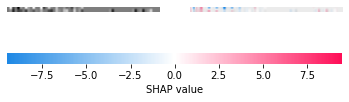

In [28]:
background = datasets['HLT_test1'][np.random.choice(datasets['HLT_test1'].shape[0], 100, replace=False)]

e = shap.DeepExplainer(HLT_AE, background)

shap_values = e.shap_values(datasets['HLT_test2'][0:2])


shap.image_plot(shap_values, -datasets['HLT_test2'][0:2])

<Figure size 864x576 with 0 Axes>

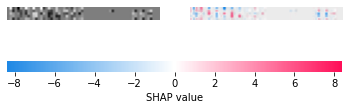

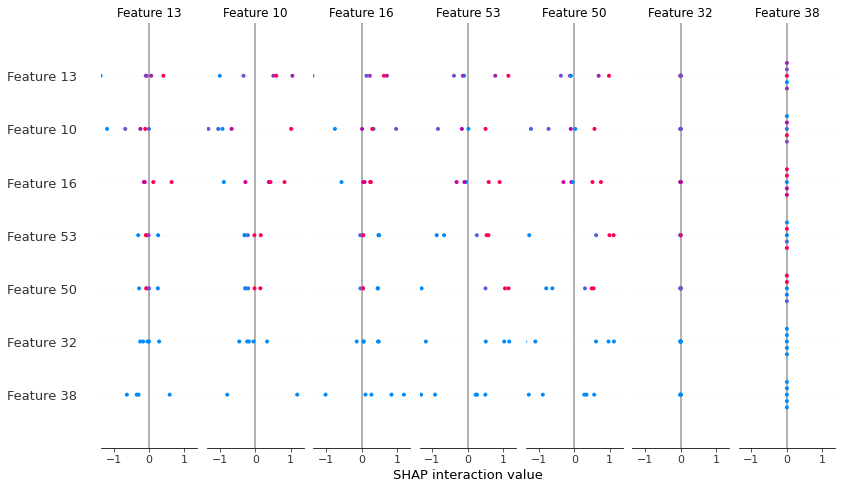

In [30]:
# Set up the background data
background = datasets['HLT_test1'][np.random.choice(datasets['HLT_test1'].shape[0], 100, replace=False)]

# Initialize SHAP DeepExplainer
e = shap.DeepExplainer(HLT_AE, background)

# Compute SHAP values for a subset of test data
shap_values = e.shap_values(datasets['HLT_test2'][0:5])

# Adjust plot size and plot SHAP values
plt.figure(figsize=(12, 8))
shap.image_plot(shap_values, -datasets['HLT_test2'][0:5])

# Alternatively, use summary plot for better insights
shap.summary_plot(shap_values, datasets['HLT_test2'][0:5])

## Normal Eval. Keep in mind these models were trained over passL1 events.

In [29]:
# Pass the datasets through the model

for tag, dict in datasets.items():
    if tag == 'EB_train': continue

    dict['HLT_model_outputs'] = HLT_AE.predict(dict['HLT_data'])
    dict['HLT_latent_reps'] = HLT_encoder.predict(dict['HLT_data'])
    dict['L1_model_outputs'] = L1_AE.predict(dict['L1_data'])
    dict['L1_latent_reps'] = L1_encoder.predict(dict['L1_data'])

# Display the structure of updated datasets
for tag, data in datasets.items():
    print(f'\n{tag}:')
    for key, value in data.items():
        print(f'{key}: {value.shape}')

5656/5656 [==============================] - 8s 1ms/step

A14N23LO:
HLT_data: (10000, 60)
L1_data: (10000, 60)
passL1: (10000,)
passHLT: (10000,)
weights: (10000,)
HLT_model_outputs: (10000, 60)
HLT_latent_reps: (10000, 3)
L1_model_outputs: (10000, 60)
L1_latent_reps: (10000, 3)

HAHMggf:
HLT_data: (70000, 60)
L1_data: (70000, 60)
passL1: (70000,)
passHLT: (70000,)
weights: (70000,)
HLT_model_outputs: (70000, 60)
HLT_latent_reps: (70000, 3)
L1_model_outputs: (70000, 60)
L1_latent_reps: (70000, 3)

HHbbttHadHad:
HLT_data: (100000, 60)
L1_data: (100000, 60)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)
HLT_model_outputs: (100000, 60)
HLT_latent_reps: (100000, 3)
L1_model_outputs: (100000, 60)
L1_latent_reps: (100000, 3)

ZZ4lep:
HLT_data: (100000, 60)
L1_data: (100000, 60)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)
HLT_model_outputs: (100000, 60)
HLT_latent_reps: (100000, 3)
L1_model_outputs: (100000, 60)
L1_latent_reps: (100000, 3)

Zprime2EJs:
HLT_data: (100000, 

In [30]:
def mse_loss(true, prediction):
    loss = np.mean(np.square(true - prediction), axis=-1)
    return loss

In [31]:
def MSE_AD_score(y, x):
    # masked mse
    mask = (y != 0) & (y != -999)
    _x = x * mask
    _y = y * mask
    return (mse_loss(_y, _x))

In [32]:
# Calculate the AD scores

for tag, dict in datasets.items():
    if tag == 'EB_train': continue

    dict['HLT_AD_scores'] = MSE_AD_score(dict['HLT_data'], dict['HLT_model_outputs'])
    dict['my_L1_AD_scores'] = MSE_AD_score(dict['L1_data'], dict['L1_model_outputs'])

# Display the structure of updated datasets
for tag, data in datasets.items():
    print(f'\n{tag}:')
    for key, value in data.items():
        print(f'{key}: {value.shape}')


A14N23LO:
HLT_data: (10000, 60)
L1_data: (10000, 60)
passL1: (10000,)
passHLT: (10000,)
weights: (10000,)
HLT_model_outputs: (10000, 60)
HLT_latent_reps: (10000, 3)
L1_model_outputs: (10000, 60)
L1_latent_reps: (10000, 3)
HLT_AD_scores: (10000,)
my_L1_AD_scores: (10000,)

HAHMggf:
HLT_data: (70000, 60)
L1_data: (70000, 60)
passL1: (70000,)
passHLT: (70000,)
weights: (70000,)
HLT_model_outputs: (70000, 60)
HLT_latent_reps: (70000, 3)
L1_model_outputs: (70000, 60)
L1_latent_reps: (70000, 3)
HLT_AD_scores: (70000,)
my_L1_AD_scores: (70000,)

HHbbttHadHad:
HLT_data: (100000, 60)
L1_data: (100000, 60)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)
HLT_model_outputs: (100000, 60)
HLT_latent_reps: (100000, 3)
L1_model_outputs: (100000, 60)
L1_latent_reps: (100000, 3)
HLT_AD_scores: (100000,)
my_L1_AD_scores: (100000,)

ZZ4lep:
HLT_data: (100000, 60)
L1_data: (100000, 60)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)
HLT_model_outputs: (100000, 60)
HLT_latent_reps: (100000,

In [33]:
# Split off the L1Seeded data
datasets['EB_L1Seeded'] = {}

for label, data in datasets['EB_eval'].items():
    if label == 'L1Seeded': continue

    datasets['EB_L1Seeded'][label] = data[datasets['EB_eval']['L1Seeded']]

# Display the structure of updated datasets
for tag, data in datasets.items():
    print(f'\n{tag}:')
    for key, value in data.items():
        print(f'{key}: {value.shape}')


A14N23LO:
HLT_data: (10000, 60)
L1_data: (10000, 60)
passL1: (10000,)
passHLT: (10000,)
weights: (10000,)
HLT_model_outputs: (10000, 60)
HLT_latent_reps: (10000, 3)
L1_model_outputs: (10000, 60)
L1_latent_reps: (10000, 3)
HLT_AD_scores: (10000,)
my_L1_AD_scores: (10000,)

HAHMggf:
HLT_data: (70000, 60)
L1_data: (70000, 60)
passL1: (70000,)
passHLT: (70000,)
weights: (70000,)
HLT_model_outputs: (70000, 60)
HLT_latent_reps: (70000, 3)
L1_model_outputs: (70000, 60)
L1_latent_reps: (70000, 3)
HLT_AD_scores: (70000,)
my_L1_AD_scores: (70000,)

HHbbttHadHad:
HLT_data: (100000, 60)
L1_data: (100000, 60)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)
HLT_model_outputs: (100000, 60)
HLT_latent_reps: (100000, 3)
L1_model_outputs: (100000, 60)
L1_latent_reps: (100000, 3)
HLT_AD_scores: (100000,)
my_L1_AD_scores: (100000,)

ZZ4lep:
HLT_data: (100000, 60)
L1_data: (100000, 60)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)
HLT_model_outputs: (100000, 60)
HLT_latent_reps: (100000,

In [34]:
# Now, I want to accept 10 Hz of the L1Seeded and calculate HLT overlap.

# Create the L1Seeded flag for the evaluation dataset
acceptance = 0
target_acceptance = 0.025

datasets['EB_L1Seeded']['HLT_anomalous'] = np.full(len(datasets['EB_L1Seeded']['event_numbers']), False, dtype=bool)

# Sort indices by AD score in descending order
sorted_indices = np.argsort(datasets['EB_L1Seeded']['HLT_AD_scores'])[::-1]

# Calculate the sum of the weights once so we don't do it every time in the loop
sum_weights = np.sum(datasets['EB_L1Seeded']['weights'])

for idx in sorted_indices:
    new_acc = acceptance + (datasets['EB_L1Seeded']['weights'][idx] / sum_weights)
    acceptance += datasets['EB_L1Seeded']['weights'][idx] / sum_weights
    datasets['EB_L1Seeded']['HLT_anomalous'][idx] = True
    if new_acc >= target_acceptance:
        break
    

    
print(acceptance)
# Display the structure of updated datasets
for tag, data in datasets.items():
    print(f'\n{tag}:')
    for key, value in data.items():
        print(f'{key}: {value.shape}')

0.0749599802285925

A14N23LO:
HLT_data: (10000, 60)
L1_data: (10000, 60)
passL1: (10000,)
passHLT: (10000,)
weights: (10000,)
HLT_model_outputs: (10000, 60)
HLT_latent_reps: (10000, 3)
L1_model_outputs: (10000, 60)
L1_latent_reps: (10000, 3)
HLT_AD_scores: (10000,)
my_L1_AD_scores: (10000,)

HAHMggf:
HLT_data: (70000, 60)
L1_data: (70000, 60)
passL1: (70000,)
passHLT: (70000,)
weights: (70000,)
HLT_model_outputs: (70000, 60)
HLT_latent_reps: (70000, 3)
L1_model_outputs: (70000, 60)
L1_latent_reps: (70000, 3)
HLT_AD_scores: (70000,)
my_L1_AD_scores: (70000,)

HHbbttHadHad:
HLT_data: (100000, 60)
L1_data: (100000, 60)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)
HLT_model_outputs: (100000, 60)
HLT_latent_reps: (100000, 3)
L1_model_outputs: (100000, 60)
L1_latent_reps: (100000, 3)
HLT_AD_scores: (100000,)
my_L1_AD_scores: (100000,)

ZZ4lep:
HLT_data: (100000, 60)
L1_data: (100000, 60)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)
HLT_model_outputs: (100000, 60)
HLT_la

In [35]:
print(np.sum(datasets['EB_L1Seeded']['HLT_anomalous']))

8


In [36]:
# Print HLT overlap
HLT_overlap = 0
inverse_overlap = 0
for a, h, w in zip(datasets['EB_L1Seeded']['HLT_anomalous'], datasets['EB_L1Seeded']['passHLT'], datasets['EB_L1Seeded']['weights']):
    if a==1 and h==1:
        HLT_overlap += w
    if a==1 or h==1:
        inverse_overlap += w

HLT_overlap /= np.sum(datasets['EB_L1Seeded']['HLT_anomalous'] * datasets['EB_L1Seeded']['weights'])
inverse_overlap /= np.sum(datasets['EB_L1Seeded']['passHLT'] * datasets['EB_L1Seeded']['weights'])

print(f'HLT overlap: {HLT_overlap}')
print(f'inverse overlap: {inverse_overlap}')

HLT overlap: 0.025414258263249452
inverse overlap: 1.2310244304896265


In [37]:
print('acceptance:')
print(np.sum(datasets['EB_L1Seeded']['HLT_anomalous'] * datasets['EB_L1Seeded']['weights']) / np.sum(datasets['EB_L1Seeded']['weights']))

print(f"rate = 400 * acceptance = {400 * np.sum(datasets['EB_L1Seeded']['HLT_anomalous'] * datasets['EB_L1Seeded']['weights']) / np.sum(datasets['EB_L1Seeded']['weights'])}")

acceptance:
0.0749599802285925
rate = 400 * acceptance = 29.983992091437


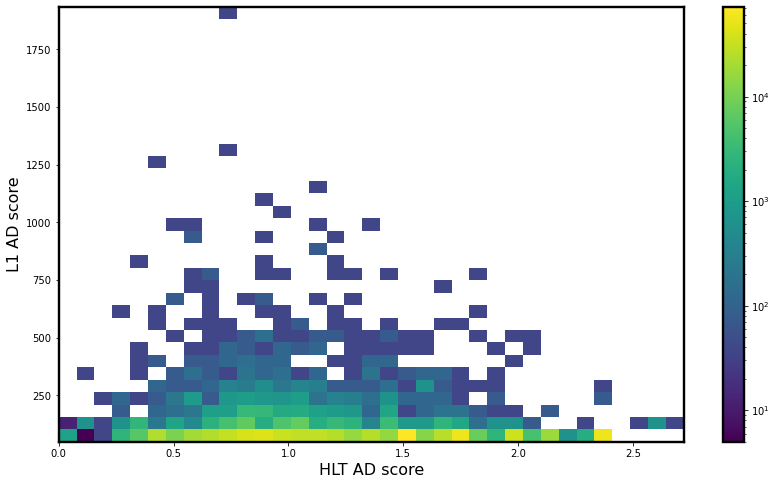

In [45]:
plt.figure(figsize=(14, 8))
plt.rcParams['axes.linewidth'] = 2.4
bins=35

plt.hist2d(datasets['EB_L1Seeded']['HLT_AD_scores'], datasets['EB_L1Seeded']['L1_AD_scores'], bins=bins, cmap='viridis', norm=matplotlib.colors.LogNorm(), weights=datasets['EB_L1Seeded']['weights'])
plt.colorbar()
plt.xlabel(f'HLT AD score', fontsize=16)
plt.ylabel(f'L1 AD score', fontsize=16)
# plt.title(f'{data1_name} vs {data2_name} Leading {object} {var}', fontsize=18)
plt.show()

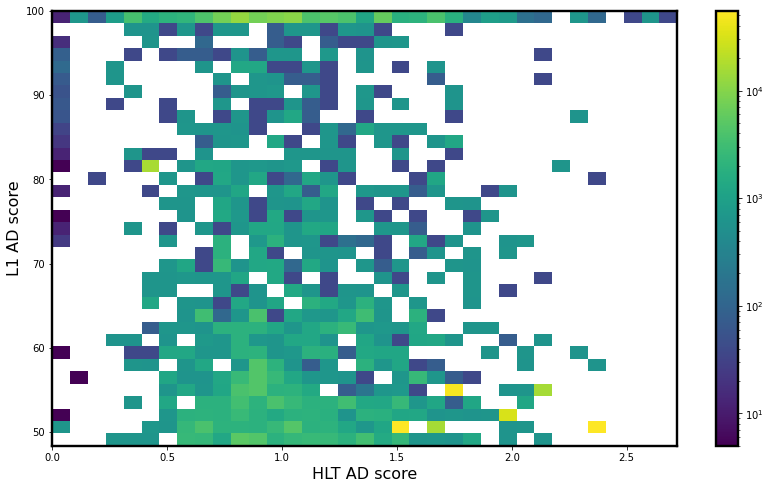

In [56]:
plt.figure(figsize=(14, 8))
plt.rcParams['axes.linewidth'] = 2.4
bins=35

plt.hist2d(datasets['EB_L1Seeded']['HLT_AD_scores'], np.clip(datasets['EB_L1Seeded']['L1_AD_scores'], a_min=0, a_max=100), bins=bins, cmap='viridis', norm=matplotlib.colors.LogNorm(), weights=datasets['EB_L1Seeded']['weights'])
plt.colorbar()
plt.xlabel(f'HLT AD score', fontsize=16)
plt.ylabel(f'L1 AD score', fontsize=16)
# plt.title(f'{data1_name} vs {data2_name} Leading {object} {var}', fontsize=18)
plt.show()

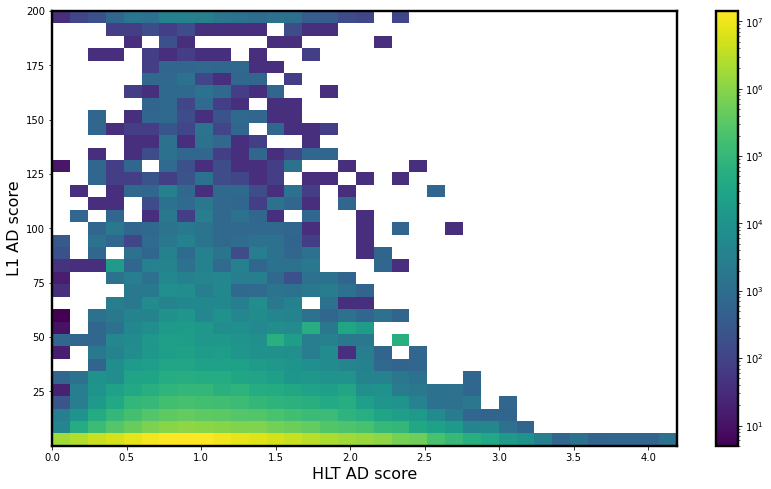

In [59]:
plt.figure(figsize=(14, 8))
plt.rcParams['axes.linewidth'] = 2.4
bins=35

plt.hist2d(datasets['EB_eval']['HLT_AD_scores'], np.clip(datasets['EB_eval']['L1_AD_scores'], a_min=0, a_max=200), bins=bins, cmap='viridis', norm=matplotlib.colors.LogNorm(), weights=datasets['EB_eval']['weights'])
plt.colorbar()
plt.xlabel(f'HLT AD score', fontsize=16)
plt.ylabel(f'L1 AD score', fontsize=16)
# plt.title(f'{data1_name} vs {data2_name} Leading {object} {var}', fontsize=18)
plt.show()

Okay, so if I train over passL1, we have 2 options:

0.76 Hz:
HLT overlap: 1.0000000000000002
inverse overlap: 1.00000000000000890

or 
29 Hz

:HLT overlap: 0.025414258263249452
inverse overlap: 1.231024430489626575

## So it seems like we really need more data

<Figure size 1296x720 with 0 Axes>

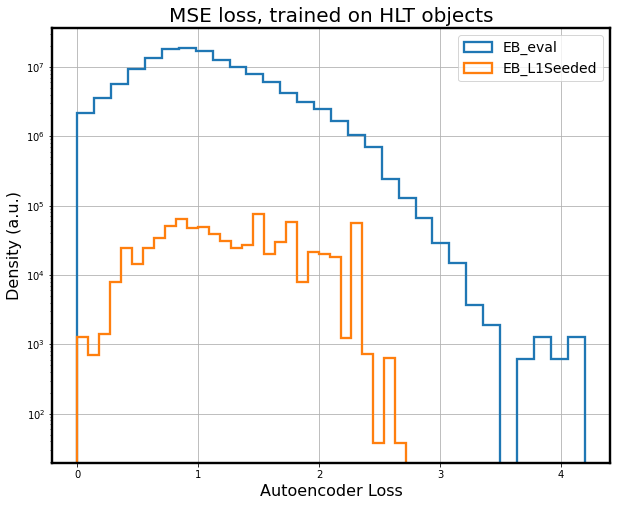

In [52]:
# Plot a histogram of the HLT AD scores

plt.figure(figsize=(18, 10))
plt.rcParams['axes.linewidth'] = 2.4

#bins = np.linspace(0, 50000, num=30)
bins=30
plt.figure(figsize=(10,8))
for tag, dict in datasets.items():
    if tag in ['EB_eval', 'EB_L1Seeded']:
        plt.hist(dict['HLT_AD_scores'], bins=bins, label=tag, density = False, histtype='step', fill=False, linewidth=2.3, weights=dict['weights'])


plt.yscale('log')
plt.xlabel("Autoencoder Loss", fontsize=16)
plt.ylabel("Density (a.u.)", fontsize=16)
plt.title('MSE loss, trained on HLT objects', fontsize=20)
plt.legend(loc='best', fontsize=14)
plt.grid()
#plt.xlim(0, 0.2 * pow(10, 6))
plt.show()

<Figure size 1296x720 with 0 Axes>

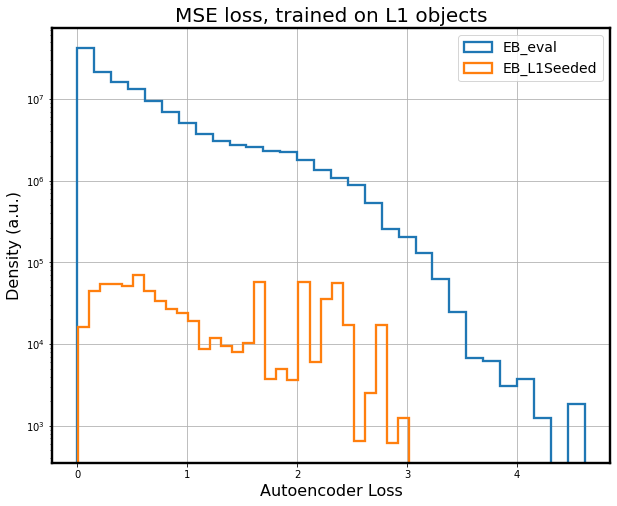

In [53]:
# Plot a histogram of the L1 AD scores

plt.figure(figsize=(18, 10))
plt.rcParams['axes.linewidth'] = 2.4

#bins = np.linspace(0, 50000, num=30)
bins=30
plt.figure(figsize=(10,8))
for tag, dict in datasets.items():
    if tag in ['EB_eval', 'EB_L1Seeded']:
        plt.hist(dict['my_L1_AD_scores'], bins=bins, label=tag, density = False, histtype='step', fill=False, linewidth=2.3, weights=dict['weights'])


plt.yscale('log')
plt.xlabel("Autoencoder Loss", fontsize=16)
plt.ylabel("Density (a.u.)", fontsize=16)
plt.title('MSE loss, trained on L1 objects', fontsize=20)
plt.legend(loc='best', fontsize=14)
plt.grid()
#plt.xlim(0, 0.2 * pow(10, 6))
plt.show()

## So this is a bit unfortunate; it seems the L1Seeded events are not the most anomalous as seen by our HLT model.

HLT_zerobias: TPR at FPR of 10^-4 is 0.00004 with threshold 3.8875
HLT_passedHLT: TPR at FPR of 10^-4 is 0.00000 with threshold 3.8875
HLT_Ztautau: TPR at FPR of 10^-4 is 0.00015 with threshold 3.8875
HLT_ZZ4lep: TPR at FPR of 10^-4 is 0.00103 with threshold 3.8875
HLT_qqa: TPR at FPR of 10^-4 is 0.00020 with threshold 3.8875
HLT_HNL7p5_ctau1_eemu: TPR at FPR of 10^-4 is 0.00040 with threshold 3.8875
HLT_Zprime2EJs: TPR at FPR of 10^-4 is 0.00011 with threshold 3.8875
HLT_HAHMggfZdZd2l2nu: TPR at FPR of 10^-4 is 0.00200 with threshold 3.8875
HLT_HHbbttHadHad: TPR at FPR of 10^-4 is 0.00114 with threshold 3.8875
HLT_jjJZ4: TPR at FPR of 10^-4 is 0.00024 with threshold 3.8875
HLT_jjJZ2: TPR at FPR of 10^-4 is 0.00016 with threshold 3.8875
HLT_test2: TPR at FPR of 10^-4 is 0.00004 with threshold 3.8875


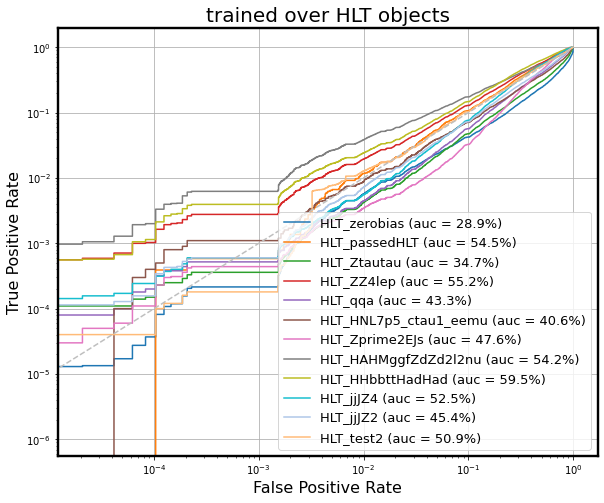

In [30]:
# Plot the HLT ROC curves

target_background = np.zeros(AD_scores['HLT_test1'].shape[0])
target_fpr = 10**-4
plt.figure(figsize=(8.5,6.8))

FPR = {}
TPR = {}
thresholds = {}

for tag in AD_scores.keys():
    if tag.startswith('HLT') and tag != 'HLT_test1':
    
        # Combine true labels, anomaly=1 and background=0
        trueVal = np.concatenate((np.ones(AD_scores[tag].shape[0]), target_background))
        
        # Combine predictions from current dataset and background
        predVal_loss = np.concatenate((AD_scores[tag], AD_scores['HLT_test1']))
    
        sample_weights = np.concatenate((weights[tag], weights['HLT_test1']))
    
        # Calculate ROC curve and AUC, including weights
        fpr_loss, tpr_loss, threshold_loss = roc_curve(y_true=trueVal, y_score=predVal_loss, sample_weight=sample_weights)
        auc_loss = auc(fpr_loss, tpr_loss)

        FPR[tag] = fpr_loss
        TPR[tag] = tpr_loss
        thresholds[tag] = threshold_loss
    
        # Plot ROC curve
        plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)' % (tag, auc_loss*100.), linewidth=1.5)
    
        # Find index where FPR is closest to 10^-4 and print TPR and threshold for that index
        idx = np.argmin(np.abs(fpr_loss - target_fpr))
        
        if tag == 'HLT_test2': 
            HLT_threshold = threshold_loss[idx]
            #plt.axvline(fpr_loss[idx], color='red', linestyle='dashed', linewidth=2, label=fpr_loss[idx])  # Threshold value
        
        print(f"{tag}: TPR at FPR of 10^-4 is {tpr_loss[idx]:.5f} with threshold {threshold_loss[idx]:.4f}")

# Set log scale for x and y axis
plt.semilogx()
plt.semilogy()

# Plot aesthetics and layout
plt.plot(np.linspace(0, 1), np.linspace(0, 1), '--', color='0.75')
plt.ylabel("True Positive Rate", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.grid(True)
plt.tight_layout()
plt.title('trained over HLT objects', fontsize=20)

# Additional plot elements

#plt.title("ROC Curve", fontsize)
plt.show()

L1_zerobias: TPR at FPR of 10^-4 is 0.00004 with threshold 4.0142
L1_passedHLT: TPR at FPR of 10^-4 is 0.00019 with threshold 4.2014
L1_HHbbttHadHad: TPR at FPR of 10^-4 is 0.00002 with threshold 4.2014
L1_jjJZ4: TPR at FPR of 10^-4 is 0.00002 with threshold 4.2014
L1_jjJZ2: TPR at FPR of 10^-4 is 0.00002 with threshold 4.2014
L1_test2: TPR at FPR of 10^-4 is 0.00004 with threshold 4.2014


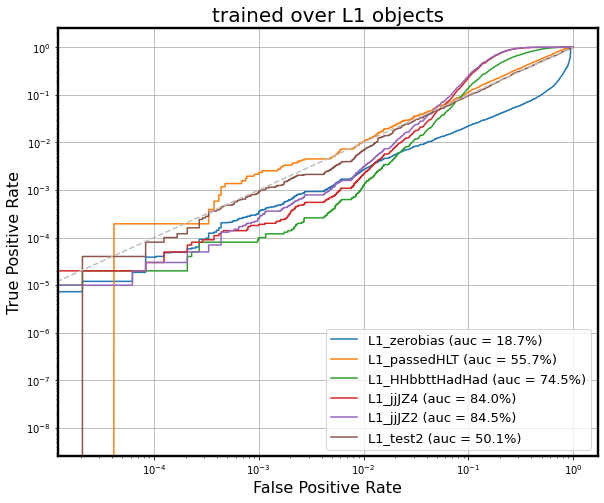

In [31]:
# Plot the HLT ROC curves

target_background = np.zeros(AD_scores['L1_test1'].shape[0])
target_fpr = 10**-4
plt.figure(figsize=(8.5,6.8))

for tag in AD_scores.keys():
    if tag.startswith('L1') and tag != 'L1_test1':
    
        # Combine true labels, anomaly=1 and background=0
        trueVal = np.concatenate((np.ones(AD_scores[tag].shape[0]), target_background))
        
        # Combine predictions from current dataset and background
        predVal_loss = np.concatenate((AD_scores[tag], AD_scores['L1_test1']))
    
        sample_weights = np.concatenate((weights[tag], weights['L1_test1']))
    
        # Calculate ROC curve and AUC, including weights
        fpr_loss, tpr_loss, threshold_loss = roc_curve(y_true=trueVal, y_score=predVal_loss, sample_weight=sample_weights)
        auc_loss = auc(fpr_loss, tpr_loss)

        FPR[tag] = fpr_loss
        TPR[tag] = tpr_loss
        thresholds[tag] = threshold_loss
    
        # Plot ROC curve
        plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)' % (tag, auc_loss*100.), linewidth=1.5)
    
        # Find index where FPR is closest to 10^-4 and print TPR and threshold for that index
        idx = np.argmin(np.abs(fpr_loss - target_fpr))
        
        if tag == 'L1_test2': 
            L1_threshold = threshold_loss[idx]
            #plt.axvline(fpr_loss[idx], color='red', linestyle='dashed', linewidth=2, label=fpr_loss[idx])  # Threshold value

        print(f"{tag}: TPR at FPR of 10^-4 is {tpr_loss[idx]:.5f} with threshold {threshold_loss[idx]:.4f}")


# Set log scale for x and y axis
plt.semilogx()
plt.semilogy()

# Plot aesthetics and layout
plt.plot(np.linspace(0, 1), np.linspace(0, 1), '--', color='0.75')
plt.ylabel("True Positive Rate", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.grid(True)
plt.tight_layout()
plt.title('trained over L1 objects', fontsize=20)

# Additional plot elements

#plt.title("ROC Curve", fontsize)
plt.show()

In [32]:
for tag in model_outputs.keys():
    if tag in skip_tags: continue
    mask = datasets[tag] != 0
    
    diff = (datasets[tag] - model_outputs[tag]) * mask
    
    mean = np.average(np.abs(diff), axis=0, weights=weights[tag])
    std = np.average((np.abs(diff) - mean)**2, axis=0).reshape(20, 3)
    mean = mean.reshape(20, 3)
    
    print(f"abs({tag} event - reconstruction)")
    for i in range(20):
        print(f'{mean[i, 0]:.3f} +- {std[i, 0]:.3f}     {mean[i, 1]:.3f} +- {std[i, 1]:.3f}     {mean[i, 2]:.3f} +- {std[i, 2]:.3f}')

abs(HLT_zerobias event - reconstruction)
0.070 +- 0.009     0.983 +- 0.926     0.981 +- 0.775
0.036 +- 0.001     1.375 +- 1.672     1.304 +- 1.045
0.024 +- 0.001     1.283 +- 1.797     1.270 +- 1.044
0.023 +- 0.000     0.604 +- 0.583     1.212 +- 1.055
0.020 +- 0.000     0.849 +- 1.199     1.143 +- 1.075
0.017 +- 0.000     0.818 +- 1.254     1.059 +- 1.091
0.014 +- 0.000     0.773 +- 1.263     0.975 +- 1.104
0.011 +- 0.000     0.700 +- 1.208     0.886 +- 1.108
0.009 +- 0.000     0.619 +- 1.129     0.804 +- 1.102
0.008 +- 0.000     0.549 +- 1.051     0.721 +- 1.083
0.000 +- 0.000     0.000 +- 0.004     0.000 +- 0.007
0.000 +- 0.000     0.000 +- 0.000     0.000 +- 0.001
0.000 +- 0.000     0.000 +- 0.000     0.000 +- 0.000
0.000 +- 0.000     0.003 +- 0.019     0.004 +- 0.044
0.000 +- 0.000     0.000 +- 0.002     0.000 +- 0.004
0.000 +- 0.000     0.000 +- 0.000     0.000 +- 0.000
0.010 +- 0.002     0.411 +- 0.464     0.409 +- 0.470
0.007 +- 0.001     0.273 +- 0.387     0.269 +- 0.399
0.003

In [33]:
HLT_mask = datasets['HLT_test1'] != 0
L1_mask = datasets['L1_test1'] != 0

HLT_diff = (datasets['HLT_test1'] - model_outputs['HLT_test1']) * HLT_mask
L1_diff = (datasets['L1_test1'] - model_outputs['L1_test1']) * L1_mask

HLT_mean = np.average(np.abs(HLT_diff), axis=0, weights=weights['HLT_test1'])
HLT_std = np.average((np.abs(HLT_diff) - HLT_mean)**2, axis=0).reshape(20, 3)
HLT_mean = HLT_mean.reshape(20, 3)

L1_mean = np.average(np.abs(L1_diff), axis=0, weights=weights['L1_test1'])
L1_std = np.average((np.abs(L1_diff) - L1_mean)**2, axis=0).reshape(20, 3)
L1_mean = L1_mean.reshape(20, 3)

print("abs(HLT event - reconstruction)")
for i in range(20):
    print(f'{HLT_mean[i, 0]:.3f} +- {HLT_std[i, 0]:.3f}     {HLT_mean[i, 1]:.3f} +- {HLT_std[i, 1]:.3f}     {HLT_mean[i, 2]:.3f} +- {HLT_std[i, 2]:.3f}')

print("abs(L1 event - reconstruction)")
for i in range(20):
    print(f'{L1_mean[i, 0]:.3f} +- {L1_std[i, 0]:.3f}     {L1_mean[i, 1]:.3f} +- {L1_std[i, 1]:.3f}     {L1_mean[i, 2]:.3f} +- {L1_std[i, 2]:.3f}')

abs(HLT event - reconstruction)
0.056 +- 0.004     1.039 +- 0.791     1.249 +- 0.744
0.039 +- 0.001     1.440 +- 1.308     1.528 +- 0.901
0.025 +- 0.001     1.680 +- 1.504     1.534 +- 0.878
0.022 +- 0.000     0.905 +- 0.642     1.513 +- 0.885
0.019 +- 0.000     1.363 +- 1.365     1.485 +- 0.914
0.017 +- 0.000     1.413 +- 1.456     1.440 +- 0.942
0.015 +- 0.000     1.407 +- 1.555     1.396 +- 0.983
0.013 +- 0.000     1.330 +- 1.583     1.312 +- 1.018
0.012 +- 0.000     1.227 +- 1.526     1.227 +- 1.050
0.011 +- 0.000     1.139 +- 1.496     1.160 +- 1.080
0.000 +- 0.000     0.003 +- 0.004     0.004 +- 0.009
0.000 +- 0.000     0.001 +- 0.001     0.001 +- 0.002
0.000 +- 0.000     0.000 +- 0.000     0.000 +- 0.000
0.006 +- 0.000     0.187 +- 0.247     0.296 +- 0.550
0.000 +- 0.000     0.020 +- 0.027     0.028 +- 0.057
0.000 +- 0.000     0.003 +- 0.004     0.004 +- 0.010
0.020 +- 0.000     0.653 +- 0.401     0.741 +- 0.442
0.019 +- 0.000     0.567 +- 0.370     0.662 +- 0.424
0.011 +- 0.000

# Everything below here is from an earlier version of the code and hasn't been updated. 
# It's left here so one can see how this kind of thing is done for ease in the future

In [31]:
# Print HLT overlaps
print(f'MODEL THAT TRAINED OVER HLT OBJECTS::::::')

for tag, data in AD_scores.items():
    if tag.startswith('HLT') and tag != 'HLT_passedHLT':
        anomaly_idxs = data > HLT_threshold
        HLT_overlap = 0
        inverse_overlap = 0
        idx = 0
        for a, h in zip(anomaly_idxs, pass_HLT[tag]):
            if a==1 and h==1:
                HLT_overlap += weights[tag][idx]
            if a==1 or h==1:
                inverse_overlap += weights[tag][idx]
            idx += 1
    
        HLT_overlap /= np.sum(anomaly_idxs * weights[tag])
        inverse_overlap /= np.sum(pass_HLT[tag] * weights[tag])
    
        print(f'-----\n{tag}:')
        print(f'HLT overlap: {HLT_overlap}')
        print(f'inverse overlap: {inverse_overlap}')
        print(f'percentage of events that passed some HLT trigger: {np.sum(pass_HLT[tag]) / len(pass_HLT[tag])}')
        print(f'percentage of events that we tagged as anomalous: {np.sum(anomaly_idxs) / len(anomaly_idxs)}')
        print(f'number of events that we tagged as anomalous: {np.sum(anomaly_idxs)}')

MODEL THAT TRAINED OVER HLT OBJECTS::::::
-----
HLT_zerobias:
HLT overlap: 0.00014975945199250689
inverse overlap: 7.728444572115307
percentage of events that passed some HLT trigger: 0.0010400489555800105
percentage of events that we tagged as anomalous: 5.913751786981518e-05
number of events that we tagged as anomalous: 46
-----
HLT_Ztautau:
HLT overlap: 0.14043583535108958
inverse overlap: 1.0533273246207
percentage of events that passed some HLT trigger: 0.06657
percentage of events that we tagged as anomalous: 0.00413
number of events that we tagged as anomalous: 413
-----
HLT_ZZ4lep:
HLT overlap: 0.9362206689965052
inverse overlap: 1.0058614361091993
percentage of events that passed some HLT trigger: 0.8718
percentage of events that we tagged as anomalous: 0.08012
number of events that we tagged as anomalous: 8012
-----
HLT_qqa:
HLT overlap: 0.1518987341772152
inverse overlap: 1.1038299756475536
percentage of events that passed some HLT trigger: 0.09034
percentage of events that 

In [32]:
# Print L1 overlaps
print(f'MODEL THAT TRAINED OVER L1 OBJECTS::::::')

for tag, data in AD_scores.items():
    if tag.startswith('L1') and tag not in ['L1_passedHLT', 'L1_zerobias']:
        anomaly_idxs = data > L1_threshold
        HLT_overlap = 0
        inverse_overlap = 0
        idx = 0
        for a, h in zip(anomaly_idxs, pass_HLT[tag]):
            if a==1 and h==1:
                HLT_overlap += weights[tag][idx]
            if a==1 or h==1:
                inverse_overlap += weights[tag][idx]
            idx += 1
    
        HLT_overlap /= np.sum(anomaly_idxs * weights[tag])
        inverse_overlap /= np.sum(pass_HLT[tag] * weights[tag])
    
        print(f'-----\n{tag}:')
        print(f'HLT overlap: {HLT_overlap}')
        print(f'inverse overlap: {inverse_overlap}')
        print(f'percentage of events that passed some HLT trigger: {np.sum(pass_HLT[tag]) / len(pass_HLT[tag])}')
        print(f'percentage of events that we tagged as anomalous: {np.sum(anomaly_idxs) / len(anomaly_idxs)}')
        print(f'number of events that we tagged as anomalous: {np.sum(anomaly_idxs)}')

MODEL THAT TRAINED OVER L1 OBJECTS::::::
-----
L1_HHbbttHadHad:
HLT overlap: 1.0
inverse overlap: 1.0
percentage of events that passed some HLT trigger: 0.5459
percentage of events that we tagged as anomalous: 3e-05
number of events that we tagged as anomalous: 3
-----
L1_jjJZ4:
HLT overlap: 0.9285714285714286
inverse overlap: 1.0000101874490628
percentage of events that passed some HLT trigger: 0.9816
percentage of events that we tagged as anomalous: 0.00014
number of events that we tagged as anomalous: 14
-----
L1_jjJZ2:
HLT overlap: 0.0
inverse overlap: 1.0074766355140188
percentage of events that passed some HLT trigger: 0.0107
percentage of events that we tagged as anomalous: 8e-05
number of events that we tagged as anomalous: 8
-----
L1_test1:
HLT overlap: 0.0
inverse overlap: 1.0048423773076038
percentage of events that passed some HLT trigger: 0.032077277076593615
percentage of events that we tagged as anomalous: 9.112862805850458e-05
number of events that we tagged as anomalou

In [33]:
threshold = HLT_threshold

anomaly_idxs = (AD_scores['HLT_test2'] > threshold) # HLT_AD_scores[1] is the test dataset of HLT data
HLT_acceptance = np.sum(weights['HLT_test2'] * pass_HLT['HLT_test2']) / np.sum(weights['HLT_test2'])
HLT_AD_acceptance = np.sum(weights['HLT_test2'] * np.bitwise_or(anomaly_idxs, pass_HLT['HLT_test2'])) / np.sum(weights['HLT_test2'])

# Multiply by 100,000 since there are 100,000Hz going INTO the HLT
# HLT_rates.append((HLT_AD_acceptance - HLT_acceptance) * 100000)
print(f'additional rate at 10e-4: {(HLT_AD_acceptance - HLT_acceptance) * 100000}')

additional rate at 10e-4: 10.050219915943432


In [48]:
HLT_rates = []
for i, fpr in enumerate(FPR['HLT_test2']):
    threshold = thresholds['HLT_test2'][i]
    
    anomaly_idxs = (AD_scores['HLT_test2'] > threshold) 
    HLT_acceptance = np.sum(weights['HLT_test2'] * pass_HLT['HLT_test2']) / np.sum(weights['HLT_test2'])
    HLT_AD_acceptance = np.sum(weights['HLT_test2'] * np.bitwise_or(anomaly_idxs, pass_HLT['HLT_test2'])) / np.sum(weights['HLT_test2'])
    
    # Multiply by 100,000 since there are 100,000Hz going INTO the HLT
    HLT_rates.append((HLT_AD_acceptance - HLT_acceptance) * 100000)

    if (i % 10000) == 1:
        print(f"progress: {i} / {len(FPR['HLT_test2'])}")

progress: 1 / 56819
progress: 10001 / 56819
progress: 20001 / 56819
progress: 30001 / 56819
progress: 40001 / 56819
progress: 50001 / 56819


In [49]:
L1_rates = []
for i, fpr in enumerate(FPR['L1_test2']):
    threshold = thresholds['L1_test2'][i]

    anomaly_idxs = (AD_scores['L1_test2'] > threshold) # HLT_AD_scores[1] is the test dataset of HLT data
    HLT_acceptance = np.sum(weights['L1_test2'] * pass_HLT['L1_test2']) / np.sum(weights['L1_test2'])
    HLT_AD_acceptance = np.sum(weights['L1_test2'] * np.bitwise_or(anomaly_idxs, pass_HLT['L1_test2'])) / np.sum(weights['L1_test2'])
    
    # Multiply by 100,000 since there are 100,000Hz going INTO the HLT
    L1_rates.append((HLT_AD_acceptance - HLT_acceptance) * 100000)

    if (i % 10000) == 1:
        print(f"progress: {i} / {len(FPR['L1_test2'])}")

progress: 1 / 56868
progress: 10001 / 56868
progress: 20001 / 56868
progress: 30001 / 56868
progress: 40001 / 56868
progress: 50001 / 56868


In [50]:
print(len(FPR['HLT_test2']))
      
print(len(HLT_rates))

56819
56819


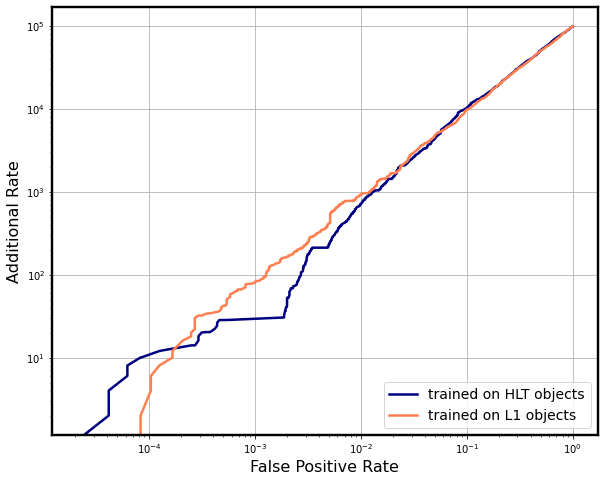

In [51]:
# Plot the additional rate vs FPR

plt.figure(figsize=(8.5,6.8))

plt.plot(FPR['HLT_test2'], HLT_rates, color='navy', linewidth=2.5, label='trained on HLT objects')
plt.plot(FPR['L1_test2'], L1_rates, color='coral', linewidth=2.5, label='trained on L1 objects')

# Set log scale for x and y axis
plt.semilogx()
plt.semilogy()

#plt.title('Trained over HLT Objects', fontsize=18)
plt.ylabel("Additional Rate", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16)
plt.legend(loc='lower right', fontsize=14)
plt.grid(True)
plt.tight_layout()

# Additional plot elements
#plt.title("ROC Curve", fontsize)
plt.show()

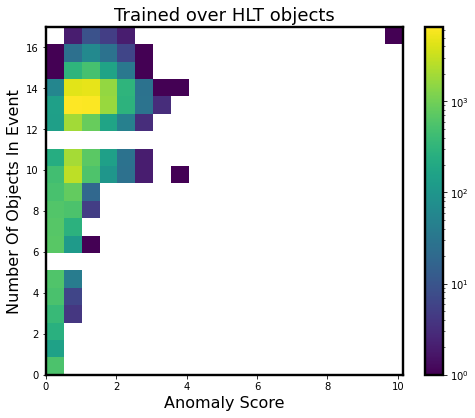

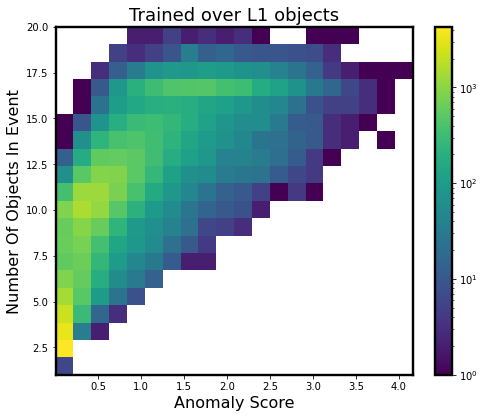

In [56]:
# Make a histogram of multiplicity vs anomaly score

HLT_pt_values = datasets['HLT_test2'].reshape(-1, 20, 3)[:, :, 0]
L1_pt_values = datasets['L1_test2'].reshape(-1, 20, 3)[:, :, 0]
HLT_num_objects = np.count_nonzero(HLT_pt_values, axis=1)
L1_num_objects = np.count_nonzero(L1_pt_values, axis=1)

plt.figure(figsize=(8, 6.4))
plt.rcParams['axes.linewidth'] = 2.4
plt.hist2d(AD_scores['HLT_test2'], HLT_num_objects, bins=20, cmap='viridis', norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.xlabel(f'Anomaly Score', fontsize=16)
plt.ylabel(f'Number Of Objects In Event', fontsize=16)
plt.title('Trained over HLT objects', fontsize=18)
plt.show()

plt.figure(figsize=(8, 6.4))
plt.rcParams['axes.linewidth'] = 2.4
plt.hist2d(AD_scores['L1_test2'], L1_num_objects, bins=20, cmap='viridis', norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.xlabel(f'Anomaly Score', fontsize=16)
plt.ylabel(f'Number Of Objects In Event', fontsize=16)
plt.title('Trained over L1 objects', fontsize=18)
plt.show()

In [39]:
# now I need to figure out, at some specific FPR, the overlap between HLT and the L1

In [40]:
HLT_anomaly_idxs = HLT_AD_scores[1] > HLT_threshold
L1_anomaly_idxs = L1_AD_scores[1] > L1_threshold

num_overlaps = np.sum(np.bitwise_and(HLT_anomaly_idxs, L1_anomaly_idxs))
num_HLT_anomalies = np.sum(HLT_anomaly_idxs)
num_L1_anomalies = np.sum(L1_anomaly_idxs)

# Calculate the fractions
f_HLT = (num_overlaps / num_HLT_anomalies)
f_L1 = (num_overlaps / num_L1_anomalies)

print(f'number of events that both the HLT and L1 models flagged as anomalous: {num_overlaps}')
print(f'out of the HLT anomalies, what fraction are also L1 anomalies? {f_HLT}')
print(f'out of the L1 anomalies, what fraction are also HLT anomalies? {f_L1}')

number of events that both the HLT and L1 models flagged as anomalous: 0
out of the HLT anomalies, what fraction are also L1 anomalies? 0.0
out of the L1 anomalies, what fraction are also HLT anomalies? 0.0


In [41]:
print(f'number of L1 anomalies: {num_L1_anomalies}')
print(f'number of HLT anomalies: {num_HLT_anomalies}')

number of L1 anomalies: 7
number of HLT anomalies: 8


In [76]:
# Let's take a closer look at these anomalies
HLT_anomalies = HLT_y_true[1][HLT_anomaly_idxs]
HLT_anom_outputs = HLT_model_outputs[1][HLT_anomaly_idxs]
L1_anomalies = L1_y_true[1][L1_anomaly_idxs]
L1_anom_outputs = L1_model_outputs[1][L1_anomaly_idxs]

print(f'Anomalies found by model trained on HLT objects:')
for i in range(len(HLT_anomalies)):
    print(f'event:\n{HLT_anomalies[i].reshape(-1, 20, 3)}')
    print(f'reconstruction:\n{HLT_anom_outputs[i].reshape(-1, 20, 3)}')

print(f'Anomalies found by model trained on L1 objects:')
for i in range(len(L1_anomalies)):
    print(f'event:\n{L1_anomalies[i].reshape(-1, 20, 3)}')
    print(f'reconstruction:\n{L1_anom_outputs[i].reshape(-1, 20, 3)}')

Anomalies found by model trained on HLT objects:
event:
[[[ 0.18945431  0.4822886  -0.30662119]
  [ 0.14006709  0.0747449   2.48758316]
  [ 0.10698286 -4.40890455  2.29233575]
  [ 0.10339661 -3.51014018 -0.84333491]
  [ 0.08084805  4.40199375 -2.6154201 ]
  [ 0.05505495  3.06775713 -2.3277216 ]
  [ 0.05356225  4.37638283  0.78126425]
  [ 0.04481367 -2.55221438 -0.62268186]
  [ 0.04245868  1.20024025  2.29764962]
  [ 0.03930756  2.72266507  3.05115509]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.06237572  0.03229186  2.51828933]
  [ 0.06237572  0.03229186  2.51828933]
  [ 0.01930252  0.49109831 -0.34072194]
  [ 0.          0.          0.        ]]]
reconstruction:
[[[ 0.07721651 -2.3509588   0.15923315]
  [ 0.09922105 -1.2720616   3.5524993 ]
  [ 0.08455377 -3.1708102  -0.55961454]
  [ 0.

In [42]:
# Print HLT overlaps
print(f'MODEL THAT TRAINED OVER HLT OBJECTS::::::')

for i, tag in enumerate(HLT_tags):
    anomaly_idxs = HLT_AD_scores[i] > HLT_threshold
    HLT_overlap = 0
    inverse_overlap = 0
    for a, h in zip(anomaly_idxs, pass_HLT_list[i]):
        if a==1 and h==1:
            HLT_overlap += 1
        if a==1 or h==1:
            inverse_overlap += 1

    HLT_overlap /= np.sum(anomaly_idxs)
    inverse_overlap /= np.sum(pass_HLT_list[i])

    print(f'-----\n{tag}:')
    print(f'HLT overlap: {HLT_overlap}')
    print(f'inverse overlap: {inverse_overlap}')
    print(f'percentage of events that passed some HLT trigger: {np.sum(pass_HLT_list[i]) / len(pass_HLT_list[i])}')
    print(f'percentage of events that we tagged as anomalous: {np.sum(anomaly_idxs) / len(anomaly_idxs)}')
    print(f'number of events that we tagged as anomalous: {np.sum(anomaly_idxs)}')

MODEL THAT TRAINED OVER HLT OBJECTS::::::
-----
data (background):
HLT overlap: 0.0
inverse overlap: 1.0028308563340411
percentage of events that passed some HLT trigger: 0.03197917845422655
percentage of events that we tagged as anomalous: 9.052845988457622e-05
number of events that we tagged as anomalous: 4
-----
HLT:
HLT overlap: 0.0
inverse overlap: 1.0056100981767182
percentage of events that passed some HLT trigger: 0.03266222313841362
percentage of events that we tagged as anomalous: 0.00018323827847637373
number of events that we tagged as anomalous: 8
-----
zerobias:
HLT overlap: 0.0
inverse overlap: 1.0469798657718121
percentage of events that passed some HLT trigger: 0.0009563236096402554
percentage of events that we tagged as anomalous: 4.492795481531401e-05
number of events that we tagged as anomalous: 7
-----
HHbbttHadHad:
HLT overlap: 0.5757575757575758
inverse overlap: 1.0038627793617216
percentage of events that passed some HLT trigger: 0.54365
percentage of events tha

In [43]:
# Print L1 overlaps
print(f'MODEL THAT TRAINED OVER L1 OBJECTS::::::')

for i, tag in enumerate(L1_tags):
    anomaly_idxs = L1_AD_scores[i] > L1_threshold
    HLT_overlap = 0
    inverse_overlap = 0
    for a, h in zip(anomaly_idxs, pass_HLT_list[i]):
        if a==1 and h==1:
            HLT_overlap += 1
        if a==1 or h==1:
            inverse_overlap += 1

    HLT_overlap /= np.sum(anomaly_idxs)
    inverse_overlap /= np.sum(pass_HLT_list[i])

    print(f'-----\n{tag}:')
    print(f'HLT overlap: {HLT_overlap}')
    print(f'inverse overlap: {inverse_overlap}')
    print(f'percentage of events that passed some HLT trigger: {np.sum(pass_HLT_list[i]) / len(pass_HLT_list[i])}')
    print(f'percentage of events that we tagged as anomalous: {np.sum(anomaly_idxs) / len(anomaly_idxs)}')
    print(f'number of events that we tagged as anomalous: {np.sum(anomaly_idxs)}')

MODEL THAT TRAINED OVER L1 OBJECTS::::::
-----
data (background):
HLT overlap: 0.2
inverse overlap: 1.0028308563340411
percentage of events that passed some HLT trigger: 0.03197917845422655
percentage of events that we tagged as anomalous: 0.00011316057485572027
number of events that we tagged as anomalous: 5
-----
L1 objects:
HLT overlap: 0.0
inverse overlap: 1.0049088359046283
percentage of events that passed some HLT trigger: 0.03266222313841362
percentage of events that we tagged as anomalous: 0.000160333493666827
number of events that we tagged as anomalous: 7
-----
zerobias:
HLT overlap: 0.0
inverse overlap: 1.0268456375838926
percentage of events that passed some HLT trigger: 0.0009563236096402554
percentage of events that we tagged as anomalous: 2.5673117037322294e-05
number of events that we tagged as anomalous: 4


In [65]:
HLT_rates = []
HLT_num_objects = []
for i, fpr in enumerate(HLT_fpr_loss):
    threshold = HLT_threshold_loss[i]

    anomaly_idxs = (HLT_AD_scores[1] > threshold) # HLT_AD_scores[1] is the test dataset of HLT data
    HLT_acceptance = np.sum(weights_list[1] * pass_HLT_list[1]) / np.sum(weights_list[1])
    HLT_AD_acceptance = np.sum(weights_list[1] * np.bitwise_or(anomaly_idxs, pass_HLT_list[1])) / np.sum(weights_list[1])

    pt_values = HLT_y_true[1][anomaly_idxs].reshape(-1, 20, 3)[:, :, 0]
    anom_weights = weights_list[1][anomaly_idxs]
    if np.sum(anom_weights)==0: anom_weights = np.ones(anom_weights.shape)
    num_objects_per_event = np.count_nonzero(pt_values, axis=1)
    #HLT_num_objects.append(np.average(num_objects_per_event, weights=anom_weights))
    HLT_num_objects.append(np.sum(num_objects_per_event * anom_weights) / np.sum(anom_weights))
    
    # Multiply by 100,000 since there are 100,000Hz going INTO the HLT
    HLT_rates.append((HLT_AD_acceptance - HLT_acceptance) * 100000)

    if (i % 10000) == 1:
        print(f'progress: {i} / {len(HLT_fpr_loss)}')

/tmp/ipykernel_372/3218523813.py:15: RuntimeWarning: invalid value encountered in double_scalars
  HLT_num_objects.append(np.sum(num_objects_per_event * anom_weights) / np.sum(anom_weights))


progress: 1 / 57940
progress: 10001 / 57940
progress: 20001 / 57940
progress: 30001 / 57940
progress: 40001 / 57940
progress: 50001 / 57940


In [66]:
L1_rates = []
L1_num_objects = []
for i, fpr in enumerate(L1_fpr_loss):
    threshold = L1_threshold_loss[i]

    anomaly_idxs = (L1_AD_scores[1] > threshold) # HLT_AD_scores[1] is the test dataset of HLT data
    HLT_acceptance = np.sum(weights_list[1] * pass_HLT_list[1]) / np.sum(weights_list[1])
    HLT_AD_acceptance = np.sum(weights_list[1] * np.bitwise_or(anomaly_idxs, pass_HLT_list[1])) / np.sum(weights_list[1])

    pt_values = L1_y_true[1][anomaly_idxs].reshape(-1, 20, 3)[:, :, 0]
    anom_weights = weights_list[1][anomaly_idxs]
    if np.sum(anom_weights)==0: anom_weights = np.ones(anom_weights.shape)
    num_objects_per_event = np.count_nonzero(pt_values, axis=1)
    L1_num_objects.append(np.sum(num_objects_per_event * anom_weights) / np.sum(anom_weights))
    
    # Multiply by 100,000 since there are 100,000Hz going INTO the HLT
    L1_rates.append((HLT_AD_acceptance - HLT_acceptance) * 100000)

    if (i % 10000) == 1:
        print(f'progress: {i} / {len(L1_fpr_loss)}')

progress: 1 / 127979
progress: 10001 / 127979
progress: 20001 / 127979
progress: 30001 / 127979
progress: 40001 / 127979
progress: 50001 / 127979
progress: 60001 / 127979
progress: 70001 / 127979
progress: 80001 / 127979
progress: 90001 / 127979
progress: 100001 / 127979
progress: 110001 / 127979
progress: 120001 / 127979


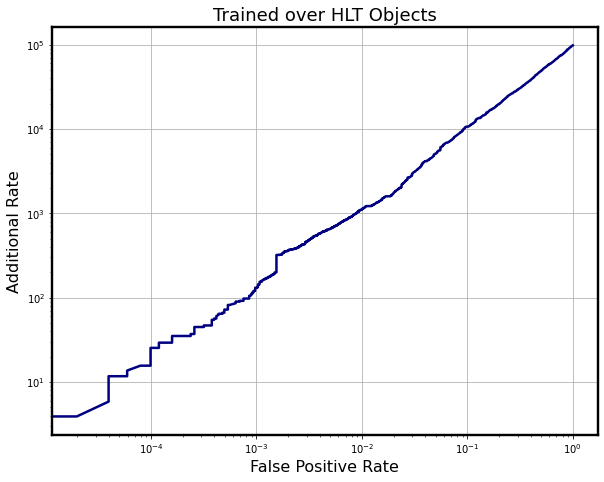

In [67]:
# Plot the additional rate vs FPR

plt.figure(figsize=(8.5,6.8))

plt.plot(HLT_fpr_loss, HLT_rates, color='navy', linewidth=2.5)

# Set log scale for x and y axis
plt.semilogx()
plt.semilogy()

plt.title('Trained over HLT Objects', fontsize=18)
plt.ylabel("Additional Rate", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16)
#plt.legend(loc='lower right', fontsize=13)
plt.grid(True)
plt.tight_layout()

# Additional plot elements
#plt.title("ROC Curve", fontsize)
plt.show()

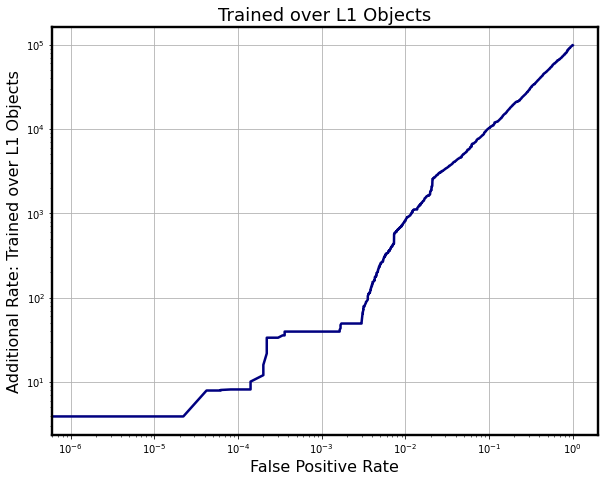

In [68]:
# Plot the additional rate vs FPR

plt.figure(figsize=(8.5,6.8))

plt.plot(L1_fpr_loss, L1_rates, color='navy', linewidth=2.5)

# Set log scale for x and y axis
plt.semilogx()
plt.semilogy()

plt.title('Trained over L1 Objects', fontsize=18)
plt.ylabel("Additional Rate: Trained over L1 Objects", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16)
#plt.legend(loc='lower right', fontsize=13)
plt.grid(True)
plt.tight_layout()

# Additional plot elements
#plt.title("ROC Curve", fontsize)
plt.show()

In [69]:
target_fpr = 10**-4
HLT_idx = np.argmin(np.abs(HLT_fpr_loss - target_fpr))
L1_idx = np.argmin(np.abs(L1_fpr_loss - target_fpr))

print(f'Pure rate at fpr=10e-4: {HLT_rates[HLT_idx]} (trained over HLT objects)')
print(f'Pure rate at fpr=10e-4: {L1_rates[L1_idx]} (trained over L1 objects)')

Pure rate at fpr=10e-4: 15.612964742042074 (trained over HLT objects)
Pure rate at fpr=10e-4: 8.156675357946785 (trained over L1 objects)


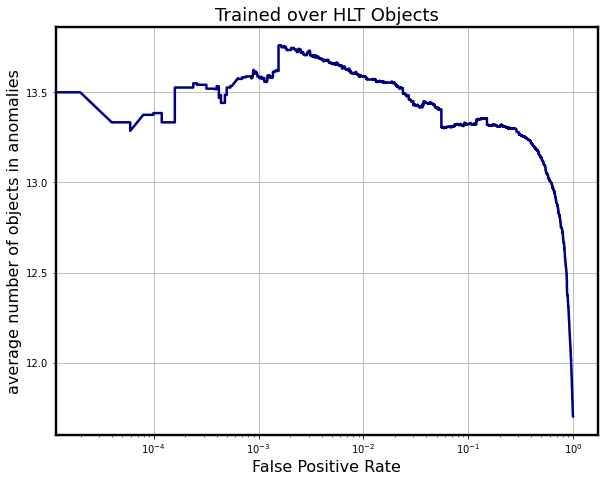

In [72]:
# Plot the additional rate vs FPR

plt.figure(figsize=(8.5,6.8))

plt.plot(HLT_fpr_loss, HLT_num_objects, color='navy', linewidth=2.5)

# Set log scale for x and y axis
plt.semilogx()
#plt.semilogy()

plt.title('Trained over HLT Objects', fontsize=18)
plt.ylabel("average number of objects in anomalies", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16)
#plt.legend(loc='lower right', fontsize=13)
plt.grid(True)
plt.tight_layout()

# Additional plot elements
#plt.title("ROC Curve", fontsize)
plt.show()

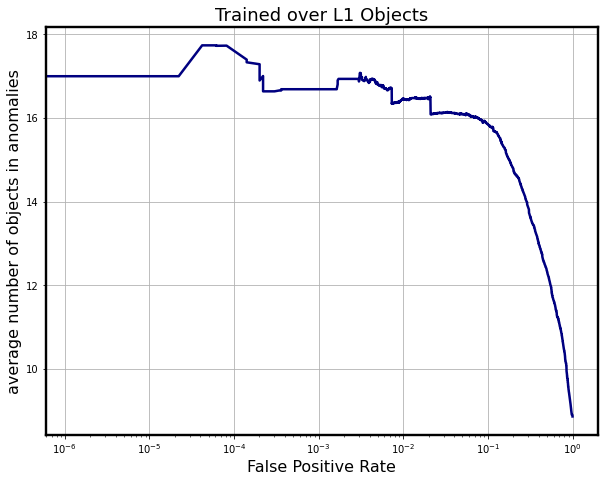

In [73]:
# Plot the additional rate vs FPR

plt.figure(figsize=(8.5,6.8))

plt.plot(L1_fpr_loss, L1_num_objects, color='navy', linewidth=2.5)

# Set log scale for x and y axis
plt.semilogx()
#plt.semilogy()

plt.title('Trained over L1 Objects', fontsize=18)
plt.ylabel("average number of objects in anomalies", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16)
#plt.legend(loc='lower right', fontsize=13)
plt.grid(True)
plt.tight_layout()

# Additional plot elements
#plt.title("ROC Curve", fontsize)
plt.show()

In [74]:
pt_values = HLT_y_true[1].reshape(-1, 20, 3)[:, :, 0]
anom_weights = weights_list[1]
if np.sum(anom_weights)==0: anom_weights = np.ones(anom_weights.shape)
num_objects_per_event = np.count_nonzero(pt_values, axis=1)
HLT_num_objs = (np.sum(num_objects_per_event * anom_weights) / np.sum(anom_weights))
print(f'average number of objects per event in the whole test data with HLT objects: {HLT_num_objs}')

average number of objects per event in the whole test data with HLT objects: 11.692775578449224


In [75]:
pt_values = L1_y_true[1].reshape(-1, 20, 3)[:, :, 0]
anom_weights = weights_list[1]
if np.sum(anom_weights)==0: anom_weights = np.ones(anom_weights.shape)
num_objects_per_event = np.count_nonzero(pt_values, axis=1)
L1_num_objs = (np.sum(num_objects_per_event * anom_weights) / np.sum(anom_weights))
print(f'average number of objects per event in the whole test data with L1 objects: {L1_num_objs}')

average number of objects per event in the whole test data with L1 objects: 8.855968094629004
